## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

Import the necessary modules:

In [1]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text

/home/sann-htet/anaconda3/envs/transformer/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-25 17:53:03.515114: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 17:53:03.749836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 17:53:03.751211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 17:53:05.874494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data handling

### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

2023-08-25 17:53:08.318436: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [3]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2023-08-25 17:53:08.675184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-08-25 17:53:08.676285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-08-25 17:53:08.754591: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

### Set up the tokenizer

Download, extract, and import the `saved_model`:

In [4]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [5]:
tokenizers = tf.saved_model.load(model_name)

In [6]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [7]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
    print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [8]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
    print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [9]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
    print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


2023-08-25 17:53:14.491317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'tokenized' with dtype int64 and shape [?]
	 [[{{node tokenized}}]]
2023-08-25 17:53:14.491501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'tokenized_1' with dtype int64 and shape [4]
	 [[{{node tokenized_1}}]]


In [10]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The distribution of tokens per example in the dataset is as follows:

In [11]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())
    
    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

2023-08-25 17:53:14.745999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-08-25 17:53:14.746924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


...................................................

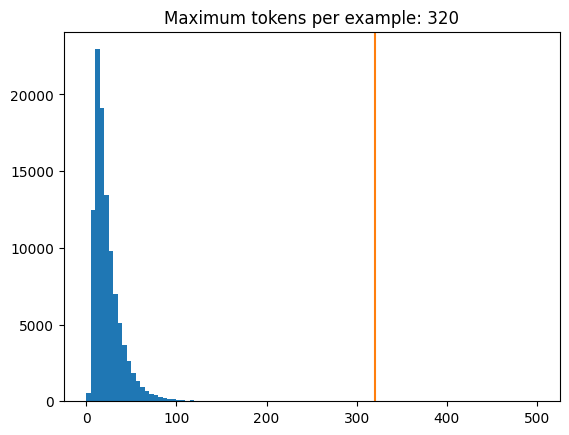

In [12]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

In [13]:
MAX_TOKENS = 128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt) # Output is ragged.
    pt = pt[:, :MAX_TOKENS] # Trim to MAX_TOKENS
    pt = pt.to_tensor() # Convert to 0-padded dense Tensor
    
    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor() # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor() # Drop the [START] tokens
    
    return (pt, en_inputs), en_labels

In [14]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [15]:
def make_batches(ds):
    return (ds
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(prepare_batch, tf.data.AUTOTUNE)
            .prefetch(buffer_size=tf.data.AUTOTUNE))

## Test the Dataset 

In [16]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [17]:
for (pt, en), en_labels in train_batches.take(1):
    break
    
print(pt.shape)
print(en.shape)
print(en_labels.shape)

2023-08-25 17:53:25.835753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_32' with dtype int64
	 [[{{node Placeholder/_32}}]]
2023-08-25 17:53:25.837192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_32' with dtype int64
	 [[{{node Placeholder/_32}}]]


(64, 73)
(64, 64)
(64, 64)


In [18]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2  45 286  13  76 534  67  45  89  50], shape=(10,), dtype=int64)
tf.Tensor([ 45 286  13  76 534  67  45  89  50   9], shape=(10,), dtype=int64)


## Define the components

The original paper uses the following formula for calculating the positional encoding:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

Note: The code below implements it, but instead of interleaving the sines and cosines, the vectors of sines and cosines are simply concatenated. Permuting the channels like this is functionally equivalent, and just a little easier to implement and show in the plots below.

In [19]:
def positional_encoding(length, depth):
    depth = depth / 2
    
    positions = np.arange(length)[:, np.newaxis] # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth # (1, depth)
    
    angle_rates = 1 / (10000*depths) # (1, depth)
    angle_rads = positions * angle_rates # (pos, depth)
    
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


/tmp/ipykernel_24839/1548430599.py:7: RuntimeWarning: divide by zero encountered in divide
  angle_rates = 1 / (10000*depths) # (1, depth)
/tmp/ipykernel_24839/1548430599.py:8: RuntimeWarning: invalid value encountered in multiply
  angle_rads = positions * angle_rates # (pos, depth)
/tmp/ipykernel_24839/1548430599.py:10: RuntimeWarning: invalid value encountered in sin
  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
/tmp/ipykernel_24839/1548430599.py:10: RuntimeWarning: invalid value encountered in cos
  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)


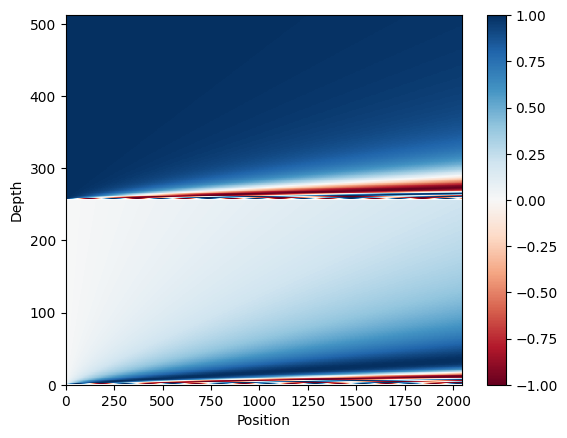

In [20]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

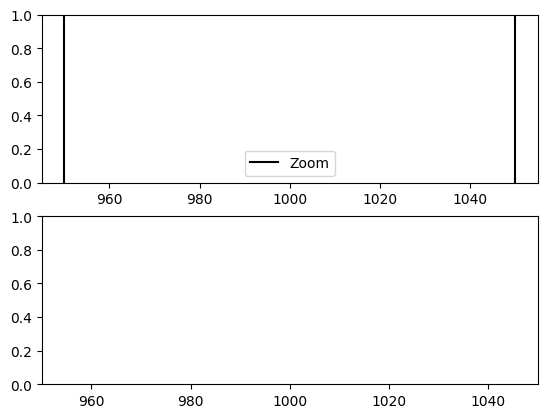

In [21]:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)

plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [22]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    # create ones matrix with zeros in upper triangular
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

In [23]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_
        len_v.
        The mask has different shapes depending on its type(padding or look
        ahead)
        but it must be broadcastable for addition.
        Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
        to (..., seq_len_q, seq_len_k). Defaults to None.
        Returns:
        output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q, seq_len_k)
    
    # scaled matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # (..., seq_len_q, seq_len_k)
    
    output = tf.matmul(attention_weights, v) # (..., seq_len_q, depth_v)
    
    return output, attention_weights

Now that the attention is defined, we need to implement the multi-head mechanism. There
are three parts: linear layers, scaled dot-product attention, and the final linear layer.

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self._dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, seq_len, 
        num_heads, depth)"""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (batch_size, seq_len_q, d_model)
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention) # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

Now, we can define a point-wise feedforward network that consists of two fully connected
layers with a ReLU activation in between:

In [27]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'), # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model) # (batch_size, seq_len, d_model)
    ])

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output) # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1) # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2) # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

Now that we have defined the encoder layer, we can use it to define the proper encoder. This
consists of three stages: input embedding, positional encoding, and N encoder layers:

In [30]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = postional_encoding(MAX_TOKENS, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding.
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            
        return x # (batch_size, input_seq_len, d_model)

We can now focus our attention on the decoder itself. It consists of output embedding, positional
encoding, and N decoder layers:

In [31]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)
        
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x) # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
            
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights